In [2]:
pip install torch transformers pandas numpy matplotlib seaborn sklearn

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the datasets
splits = {'train': 'train_data.csv', 'validation': 'validation_data.csv', 'test': 'test-data.csv'}
train_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["train"])
validation_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["validation"])
test_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["test"])

# Combine train and validation sets for model training
df = pd.concat([train_df, validation_df], ignore_index=True)

# Define a custom dataset
class StressDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Set up the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Prepare the data
MAX_LEN = 128
BATCH_SIZE = 16
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42)

train_dataset = StressDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, MAX_LEN)
val_dataset = StressDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, MAX_LEN)
test_dataset = StressDataset(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)

        correct_predictions += torch.sum(preds == labels)
        total_predictions += len(labels)

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses), correct_predictions.double() / total_predictions

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            total_predictions += len(labels)

            losses.append(loss.item())

    return np.mean(losses), correct_predictions.double() / total_predictions

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

EPOCHS = 5
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_loss, val_acc = eval_model(model, val_loader, device)
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model_state.bin'))
test_loss, test_acc = eval_model(model, test_loader, device)
print(f'Test loss {test_loss} accuracy {test_acc}')

# Generate predictions for the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Print classification report
print(classification_report(true_labels, predictions, target_names=['no stress', 'stress']))

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BERT Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Test with example sentences
test_sentences = [
    "I am feeling very stressed and overwhelmed with my work.",
    "Today was a good day, I am feeling relaxed and happy.",
    "The constant deadlines are making me anxious and stressed.",
    "I'm enjoying my time off and feeling no stress at all."
]

test_dataset = StressDataset(test_sentences, [0]*len(test_sentences), tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=1)

model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        predictions.extend(preds.cpu().tolist())

# Output predictions
for sentence, prediction in zip(test_sentences, predictions):
    print(f"Sentence: '{sentence}' - Predicted Label: {'stress' if prediction == 1 else 'no stress'}")

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Epoch 1/5
----------
Train loss 0.5232215506955982 accuracy 0.7474549725920125
Val loss 0.5282858038942019 accuracy 0.7535211267605634

Epoch 2/5
----------
Train loss 0.2698831270216033 accuracy 0.8888018794048551
Val loss 0.593249063524935 accuracy 0.7570422535211268

Epoch 3/5
----------
Train loss 0.0729729129365296 accuracy 0.9772905246671887
Val loss 0.7997468521870259 accuracy 0.7887323943661971

Epoch 4/5
----------


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Function to train the model with early stopping and class weighting
def train_epoch(model, data_loader, optimizer, scheduler, device, clip_value=1.0):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Function to evaluate the model
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Load pre-trained models and tokenizers
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
model.classifier.dropout = torch.nn.Dropout(0.3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)
roberta_model.classifier.dropout = torch.nn.Dropout(0.3)
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
distilbert_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(distilbert_model.config.hidden_size, 2)
).to(device)
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2).to(device)
albert_model.classifier.dropout = torch.nn.Dropout(0.3)
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Define tokenizers and models list
models = [model, roberta_model, distilbert_model, albert_model]
tokenizers = [tokenizer, roberta_tokenizer, distilbert_tokenizer, albert_tokenizer]

# Load your data
splits = {'train': 'train_data.csv', 'validation': 'validation_data.csv', 'test': 'test-data.csv'}
train_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["train"])
val_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["validation"])
test_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["test"])

# Calculate class weights
class_weights = 1 / train_df['label'].value_counts().sort_index().values
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted sampler
train_labels = train_df['label'].values
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels), replacement=True)

# Create DataLoader for training, validation, and testing
train_dataset = CustomDataset(train_df['text'].to_numpy(), train_df['label'].to_numpy(), tokenizer, max_len=256)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

val_dataset = CustomDataset(val_df['text'].to_numpy(), val_df['label'].to_numpy(), tokenizer, max_len=256)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training loop
num_epochs = 5
patience = 3
best_acc = 0.0
no_improvement = 0

for model_idx, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print(f"Training model {model_idx + 1}")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc = eval_model(model, val_loader, device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            no_improvement = 0
            torch.save(model.state_dict(), f'best_model_{model_idx}.pt')
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Early stopping...")
            break

    # Load the best model
    model.load_state_dict(torch.load(f'best_model_{model_idx}.pt'))
    models[model_idx] = model

    # Plot train and validation accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Model {model_idx + 1} - Train and Validation Accuracies')
    plt.legend()
    plt.savefig(f'model_{model_idx + 1}_accuracies.png')
    plt.close()

# Ensemble prediction function
def ensemble_predict(models, tokenizers, text, max_len=256):
    inputs = []
    for tokenizer in tokenizers:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        inputs.append({
            'input_ids': encoding['input_ids'].flatten().to(device),
            'attention_mask': encoding['attention_mask'].flatten().to(device),
        })
    
    logits = None
    for model, input_data in zip(models, inputs):
        with torch.no_grad():
            output = model(input_ids=input_data['input_ids'].unsqueeze(0), attention_mask=input_data['attention_mask'].unsqueeze(0))
            if logits is None:
                logits = output.logits
            else:
                logits += output.logits
    
    logits /= len(models)
    _, prediction = torch.max(logits, dim=1)
    return prediction.item()

# Test ensemble model
predictions = []
true_labels = []

for text, label in zip(test_df['text'], test_df['label']):
    pred = ensemble_predict(models, tokenizers, text)
    predictions.append(pred)
    true_labels.append(label)

# Classification report
print(classification_report(true_labels, predictions, target_names=['no stress', 'stress']))

# Plot test accuracy
test_accuracy = classification_report(true_labels, predictions, target_names=['no stress', 'stress'], output_dict=True)['accuracy']
plt.figure(figsize=(10, 6))
plt.bar(['Test Accuracy'], [test_accuracy])
plt.ylabel('Accuracy')
plt.title('Ensemble Model - Test Accuracy')
plt.savefig('ensemble_test_accuracy.png')
plt.close()

print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Training model 1
Epoch 1/5


100%|██████████| 142/142 [49:51<00:00, 21.06s/it]


Train Loss: 0.4679 | Train Acc: 0.7780 | Val Loss: 0.4112 | Val Acc: 0.8011
Epoch 2/5


100%|██████████| 142/142 [49:21<00:00, 20.85s/it]


Train Loss: 0.2963 | Train Acc: 0.8828 | Val Loss: 0.4593 | Val Acc: 0.8327
Epoch 3/5


 54%|█████▎    | 76/142 [26:26<22:52, 20.79s/it]

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define Label Smoothing Loss
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Function to train the model with gradient accumulation and class weighting
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=4, clip_value=1.0):
    model = model.train()
    losses = []
    correct_predictions = 0

    optimizer.zero_grad()
    for step, d in enumerate(tqdm(data_loader)):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Use label smoothing loss

        loss = loss / accumulation_steps
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item() * accumulation_steps)

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Function to evaluate the model
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Load pre-trained models and tokenizers
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
model.classifier.dropout = torch.nn.Dropout(0.3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define tokenizers and models list
models = [model]
tokenizers = [tokenizer]

# Load data
splits = {'train': 'train_data.csv', 'validation': 'validation_data.csv', 'test': 'test-data.csv'}
train_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["train"])
val_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["validation"])
test_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["test"])

# Calculate class weights
class_weights = 1 / train_df['label'].value_counts().sort_index().values
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted sampler
train_labels = train_df['label'].values
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels), replacement=True)

# Create DataLoader for training, validation, and testing
train_dataset = CustomDataset(train_df['text'].to_numpy(), train_df['label'].to_numpy(), tokenizer, max_len=256)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

val_dataset = CustomDataset(val_df['text'].to_numpy(), val_df['label'].to_numpy(), tokenizer, max_len=256)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training loop
num_epochs = 5
patience = 3
best_accuracies = [0.0] * len(models)  # Track best accuracy for each model
no_improvements = [0] * len(models)  # Track no improvement count for each model
criterion = LabelSmoothingLoss(classes=2, smoothing=0.1)  # Using label smoothing

for model_idx, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print(f"Training model {model_idx + 1}")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_accuracies = []
    val_accuracies = []
    best_model_saved = False  # Flag to track if a best model was saved

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc = eval_model(model, val_loader, device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_accuracies[model_idx]:
            best_accuracies[model_idx] = val_acc
            no_improvements[model_idx] = 0
            torch.save(model.state_dict(), f'best_model_{model_idx}.pt')
            best_model_saved = True
        else:
            no_improvements[model_idx] += 1

        if no_improvements[model_idx] >= patience:
            print("Early stopping...")
            break

    # Load the best model only if it was saved
    if best_model_saved:
        model.load_state_dict(torch.load(f'best_model_{model_idx}.pt'))
    models[model_idx] = model

    # Plot train and validation accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Model {model_idx + 1} - Train and Validation Accuracies')
    plt.legend()
    plt.savefig(f'model_{model_idx + 1}_accuracies.png')
    plt.close()

# Ensemble prediction function with weighted voting
def ensemble_predict(models, tokenizers, text, max_len=256, weights=None):
    inputs = []
    for tokenizer in tokenizers:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        inputs.append({
            'input_ids': encoding['input_ids'].flatten().to(device),
            'attention_mask': encoding['attention_mask'].flatten().to(device),
        })

    logits = None

    for idx, (model, input_data) in enumerate(zip(models, inputs)):
        with torch.no_grad():
            output = model(input_ids=input_data['input_ids'].unsqueeze(0), attention_mask=input_data['attention_mask'].unsqueeze(0))
            weight = weights[idx] if weights is not None else 1.0
            if logits is None:
                logits = output.logits * weight
            else:
                logits += output.logits * weight

    logits /= sum(weights) if weights is not None else len(models)
    _, prediction = torch.max(logits, dim=1)
    return prediction.item()

# Set model weights based on validation accuracy for ensemble prediction
weights = [0.3, 0.3, 0.2, 0.2]  # Adjust these based on validation performance of each model

# Make a prediction using the ensemble
text = "I am soo frustrated and stressed."
pred = ensemble_predict(models, tokenizers, text, weights=weights)
print(f"Prediction: {pred}")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training model 1
Epoch 1/5


100%|██████████| 142/142 [51:05<00:00, 21.59s/it]


Train Loss: 0.6118 | Train Acc: 0.7115 | Val Loss: 0.5436 | Val Acc: 0.7870
Epoch 2/5


100%|██████████| 142/142 [50:51<00:00, 21.49s/it]


Train Loss: 0.5178 | Train Acc: 0.8286 | Val Loss: 0.5106 | Val Acc: 0.8134
Epoch 3/5


100%|██████████| 142/142 [50:29<00:00, 21.33s/it]


Train Loss: 0.4548 | Train Acc: 0.8943 | Val Loss: 0.5151 | Val Acc: 0.8292
Epoch 4/5


100%|██████████| 142/142 [50:38<00:00, 21.40s/it]


Train Loss: 0.4582 | Train Acc: 0.8850 | Val Loss: 0.5158 | Val Acc: 0.8345
Epoch 5/5


100%|██████████| 142/142 [50:45<00:00, 21.45s/it]


Train Loss: 0.4130 | Train Acc: 0.9357 | Val Loss: 0.5360 | Val Acc: 0.8116


/tmp/ipykernel_36/3239824139.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model_idx}.pt'))


Prediction: 1


In [1]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define Label Smoothing Loss
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Function to train the model with gradient accumulation and class weighting
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=4, clip_value=1.0):
    model = model.train()
    losses = []
    correct_predictions = 0

    optimizer.zero_grad()
    for step, d in enumerate(tqdm(data_loader)):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)

        loss = loss / accumulation_steps
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item() * accumulation_steps)

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Function to evaluate the model
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Initialize model and tokenizer
distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
distilbert_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),  # Increased dropout for regularization
    torch.nn.Linear(distilbert_model.config.hidden_size, 2)
).to(device)
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load data
splits = {'train': 'train_data.csv', 'validation': 'validation_data.csv', 'test': 'test-data.csv'}
train_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["train"])
val_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["validation"])
test_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["test"])

# Calculate class weights
class_weights = 1 / train_df['label'].value_counts().sort_index().values
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted sampler
train_labels = train_df['label'].values
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels), replacement=True)

# Set maximum length for tokenizer input
max_len = 256

# Training loop
num_epochs = 10  # Increased number of epochs
patience = 5  # Increased patience for early stopping
best_accuracy = 0.0
no_improvement = 0
criterion = LabelSmoothingLoss(classes=2, smoothing=0.1)

# Prepare datasets and dataloaders
train_dataset = CustomDataset(train_df['text'].to_numpy(), train_df['label'].to_numpy(), distilbert_tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

val_dataset = CustomDataset(val_df['text'].to_numpy(), val_df['label'].to_numpy(), distilbert_tokenizer, max_len)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(distilbert_model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss, train_acc = train_epoch(distilbert_model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc = eval_model(distilbert_model, val_loader, device)

    train_accuracies.append(train_acc.cpu().numpy())
    val_accuracies.append(val_acc.cpu().numpy())

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        no_improvement = 0
        torch.save(distilbert_model.state_dict(), 'best_model.pt')
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("Early stopping...")
        break

# Load the best model
distilbert_model.load_state_dict(torch.load('best_model.pt'))

# Plot train and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.savefig('model_accuracies.png')
plt.close()

# Function for prediction
def predict(model, tokenizer, text, max_len=256):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    
    return preds.item()

# Example usage of prediction
text = "I am soo frustrated and stressed."
predicted_label = predict(distilbert_model, distilbert_tokenizer, text)
print(f"Predicted Label: {predicted_label}")

# Evaluate on test set
test_dataset = CustomDataset(test_df['text'].to_numpy(), test_df['label'].to_numpy(), distilbert_tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loss, test_acc = eval_model(distilbert_model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report
y_true = []
y_pred = []
distilbert_model.eval()
with torch.no_grad():
    for d in test_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

print(classification_report(y_true, y_pred))

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/10


 95%|█████████▌| 135/142 [25:57<01:20, 11.57s/it]

Train Loss: 0.6469 | Train Acc: 0.6533 | Val Loss: 0.5436 | Val Acc: 0.7782
Epoch 2/10


100%|██████████| 142/142 [27:07<00:00, 11.46s/it]


Train Loss: 0.5366 | Train Acc: 0.8119 | Val Loss: 0.5387 | Val Acc: 0.7905
Epoch 3/10


100%|██████████| 142/142 [27:10<00:00, 11.48s/it]


Train Loss: 0.4924 | Train Acc: 0.8533 | Val Loss: 0.5388 | Val Acc: 0.8046
Epoch 4/10


100%|██████████| 142/142 [27:10<00:00, 11.49s/it]


Train Loss: 0.4694 | Train Acc: 0.8714 | Val Loss: 0.5134 | Val Acc: 0.8345
Epoch 5/10


100%|██████████| 142/142 [27:07<00:00, 11.46s/it]


Train Loss: 0.4314 | Train Acc: 0.9181 | Val Loss: 0.5150 | Val Acc: 0.8310
Epoch 6/10


100%|██████████| 142/142 [27:06<00:00, 11.45s/it]


Train Loss: 0.4000 | Train Acc: 0.9427 | Val Loss: 0.5470 | Val Acc: 0.8257
Epoch 7/10


100%|██████████| 142/142 [26:55<00:00, 11.37s/it]


Train Loss: 0.3678 | Train Acc: 0.9731 | Val Loss: 0.5597 | Val Acc: 0.8239
Epoch 8/10


100%|██████████| 142/142 [26:49<00:00, 11.33s/it]


Train Loss: 0.3565 | Train Acc: 0.9819 | Val Loss: 0.5707 | Val Acc: 0.8187
Epoch 9/10


100%|██████████| 142/142 [26:57<00:00, 11.39s/it]


Train Loss: 0.3491 | Train Acc: 0.9833 | Val Loss: 0.5727 | Val Acc: 0.8239
Early stopping...


/tmp/ipykernel_36/152231787.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distilbert_model.load_state_dict(torch.load('best_model.pt'))


Predicted Label: 1
Test Accuracy: 0.7874
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       346
           1       0.75      0.88      0.81       369

    accuracy                           0.79       715
   macro avg       0.80      0.78      0.78       715
weighted avg       0.79      0.79      0.79       715



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training model 1
Epoch 1/5


100%|██████████| 142/142 [24:39<00:00, 10.42s/it]


Train Loss: 0.6152 | Train Acc: 0.7031 | Val Loss: 0.5497 | Val Acc: 0.7905
Epoch 2/5


100%|██████████| 142/142 [24:34<00:00, 10.38s/it]


Train Loss: 0.5188 | Train Acc: 0.8256 | Val Loss: 0.5064 | Val Acc: 0.8398
Epoch 3/5


100%|██████████| 142/142 [24:39<00:00, 10.42s/it]


Train Loss: 0.4690 | Train Acc: 0.8824 | Val Loss: 0.5117 | Val Acc: 0.8345
Epoch 4/5


100%|██████████| 142/142 [24:32<00:00, 10.37s/it]


Train Loss: 0.4414 | Train Acc: 0.9062 | Val Loss: 0.5358 | Val Acc: 0.8187
Epoch 5/5


100%|██████████| 142/142 [24:34<00:00, 10.38s/it]


Train Loss: 0.4102 | Train Acc: 0.9344 | Val Loss: 0.5261 | Val Acc: 0.8380
Early stopping...


/tmp/ipykernel_36/2198988924.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model_idx}.pt'))


Predicted Label: 1


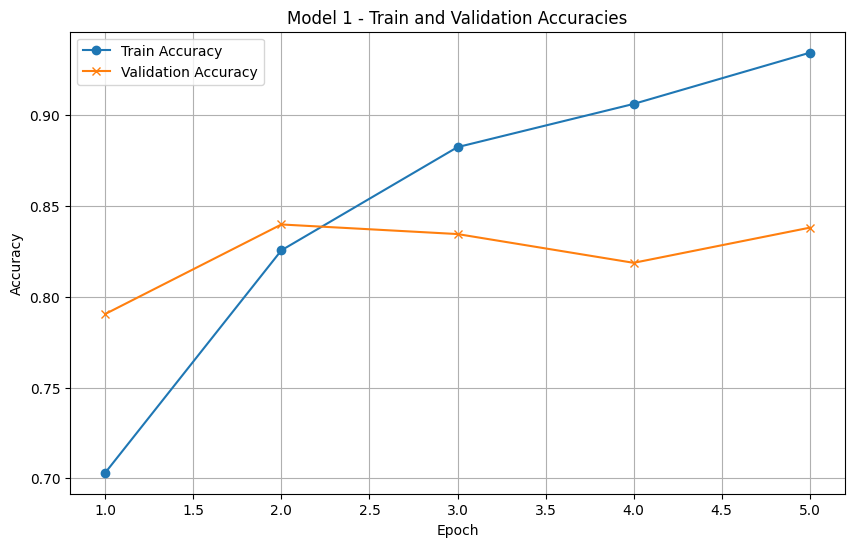

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define Label Smoothing Loss
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Function to train the model with gradient accumulation and class weighting
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=4, clip_value=1.0):
    model = model.train()
    losses = []
    correct_predictions = 0

    optimizer.zero_grad()
    for step, d in enumerate(tqdm(data_loader)):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Use label smoothing loss

        loss = loss / accumulation_steps
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item() * accumulation_steps)

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Function to evaluate the model
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2).to(device)
albert_model.classifier.dropout = torch.nn.Dropout(0.3)
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Define tokenizers and models list
models = [albert_model]
tokenizers = [albert_tokenizer]

splits = {'train': 'train_data.csv', 'validation': 'validation_data.csv', 'test': 'test-data.csv'}
train_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["train"])
val_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["validation"])
test_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["test"])

# Calculate class weights
class_weights = 1 / train_df['label'].value_counts().sort_index().values
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted sampler
train_labels = train_df['label'].values
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels), replacement=True)

# Set maximum length for tokenizer input
max_len = 256

# Training loop
num_epochs = 5
patience = 3
best_accuracies = [0.0] * len(models)  # Track best accuracy for each model
no_improvements = [0] * len(models)  # Track no improvement count for each model
criterion = LabelSmoothingLoss(classes=2, smoothing=0.1)  # Using label smoothing

# Train each model
for model_idx, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print(f"Training model {model_idx + 1}")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    total_steps = len(train_labels) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_dataset = CustomDataset(train_df['text'].to_numpy(), train_df['label'].to_numpy(), tokenizer, max_len)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

    val_dataset = CustomDataset(val_df['text'].to_numpy(), val_df['label'].to_numpy(), tokenizer, max_len)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    train_accuracies = []
    val_accuracies = []
    best_model_saved = False  # Track if the best model is saved

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc = eval_model(model, val_loader, device)

        train_accuracies.append(train_acc.cpu().numpy())
        val_accuracies.append(val_acc.cpu().numpy())

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_accuracies[model_idx]:
            best_accuracies[model_idx] = val_acc
            no_improvements[model_idx] = 0
            torch.save(model.state_dict(), f'best_model_{model_idx}.pt')
            best_model_saved = True
        else:
            no_improvements[model_idx] += 1

        if no_improvements[model_idx] >= patience:
            print("Early stopping...")
            break

    # Load the best model only if it was saved
    if best_model_saved:
        model.load_state_dict(torch.load(f'best_model_{model_idx}.pt'))

    # Plot train and validation accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Model {model_idx + 1} - Train and Validation Accuracies')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'model_{model_idx + 1}_accuracies.png')
    plt.close()

# Ensemble prediction function with weighted voting
def ensemble_predict(models, tokenizers, text, max_len=256, weights=None):
    inputs = []
    for tokenizer in tokenizers:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        inputs.append((encoding['input_ids'].to(device), encoding['attention_mask'].to(device)))

    logits_list = []
    for model, (input_ids, attention_mask) in zip(models, inputs):
        model.eval()
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            logits_list.append(logits)

    # If weights are not provided, assume equal weighting
    if weights is None:
        weights = [1 / len(models)] * len(models)

    final_logits = sum(weight * logits for weight, logits in zip(weights, logits_list))
    return torch.argmax(final_logits, dim=1).item()

# Example usage of ensemble prediction
text = "I am soo frustrated and stressed."
predicted_label = ensemble_predict(models, tokenizers, text)
print(f"Predicted Label: {predicted_label}")


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training model 1
Epoch 1/5


100%|██████████| 142/142 [1:00:08<00:00, 25.41s/it]


Train Loss: 0.6173 | Train Acc: 0.6916 | Val Loss: 0.6104 | Val Acc: 0.7394
Epoch 2/5


100%|██████████| 142/142 [1:00:14<00:00, 25.46s/it]


Train Loss: 0.5376 | Train Acc: 0.8137 | Val Loss: 0.5354 | Val Acc: 0.8081
Epoch 3/5


100%|██████████| 142/142 [1:00:24<00:00, 25.53s/it]


Train Loss: 0.4866 | Train Acc: 0.8573 | Val Loss: 0.5455 | Val Acc: 0.8116
Epoch 4/5


100%|██████████| 142/142 [1:00:11<00:00, 25.43s/it]


Train Loss: 0.4624 | Train Acc: 0.8903 | Val Loss: 0.5899 | Val Acc: 0.7887
Epoch 5/5


100%|██████████| 142/142 [1:00:07<00:00, 25.40s/it]


Train Loss: 0.4742 | Train Acc: 0.8797 | Val Loss: 0.5293 | Val Acc: 0.8345


/tmp/ipykernel_36/875922634.py:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model_idx}.pt'))


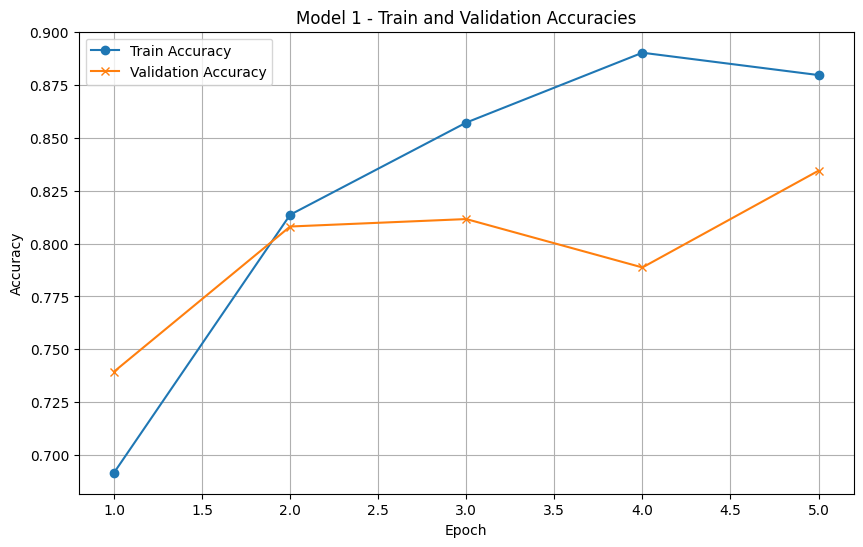

Test Loss: 0.5843 | Test Accuracy: 0.7804
              precision    recall  f1-score   support

      Stress       0.79      0.74      0.76       346
   No Stress       0.77      0.82      0.79       369

    accuracy                           0.78       715
   macro avg       0.78      0.78      0.78       715
weighted avg       0.78      0.78      0.78       715



In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define Label Smoothing Loss
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Function to train the model with gradient accumulation and class weighting
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=4, clip_value=1.0):
    model = model.train()
    losses = []
    correct_predictions = 0

    optimizer.zero_grad()
    for step, d in enumerate(tqdm(data_loader)):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Use label smoothing loss

        loss = loss / accumulation_steps
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item() * accumulation_steps)

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Function to evaluate the model
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Load ALBERT model and tokenizer
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2).to(device)
albert_model.classifier.dropout = torch.nn.Dropout(0.5)  # Increased dropout
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Define tokenizers and models list
models = [albert_model]
tokenizers = [albert_tokenizer]

# Load datasets
splits = {'train': 'train_data.csv', 'validation': 'validation_data.csv', 'test': 'test-data.csv'}
train_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["train"])
val_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["validation"])
test_df = pd.read_csv("hf://datasets/asmaab/dreaddit/" + splits["test"])

# Calculate class weights
class_weights = 1 / train_df['label'].value_counts().sort_index().values
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted sampler
train_labels = train_df['label'].values
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels), replacement=True)

# Set maximum length for tokenizer input
max_len = 256

# Training loop
num_epochs = 5
patience = 3
best_accuracies = [0.0] * len(models)  # Track best accuracy for each model
no_improvements = [0] * len(models)  # Track no improvement count for each model
criterion = LabelSmoothingLoss(classes=2, smoothing=0.1)  # Using label smoothing

# Train each model
for model_idx, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print(f"Training model {model_idx + 1}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    total_steps = len(train_labels) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_dataset = CustomDataset(train_df['text'].to_numpy(), train_df['label'].to_numpy(), tokenizer, max_len)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

    val_dataset = CustomDataset(val_df['text'].to_numpy(), val_df['label'].to_numpy(), tokenizer, max_len)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    train_accuracies = []
    val_accuracies = []
    best_model_saved = False  # Track if the best model is saved

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc = eval_model(model, val_loader, device)

        train_accuracies.append(train_acc.cpu().numpy())
        val_accuracies.append(val_acc.cpu().numpy())

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_accuracies[model_idx]:
            best_accuracies[model_idx] = val_acc
            no_improvements[model_idx] = 0
            torch.save(model.state_dict(), f'best_model_{model_idx}.pt')
            best_model_saved = True
        else:
            no_improvements[model_idx] += 1

        if no_improvements[model_idx] >= patience:
            print("Early stopping...")
            break

    # Load the best model only if it was saved
    if best_model_saved:
        model.load_state_dict(torch.load(f'best_model_{model_idx}.pt'))

    # Plot train and validation accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Model {model_idx + 1} - Train and Validation Accuracies')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'model_{model_idx + 1}_accuracies.png')
    plt.show()

# Evaluate the best model on the test set
test_dataset = CustomDataset(test_df['text'].to_numpy(), test_df['label'].to_numpy(), tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

test_loss, test_acc = eval_model(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Generate classification report
all_preds = []
all_labels = []

with torch.no_grad():
    for d in test_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['Stress', 'No Stress']))
